https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

https://www.kaggle.com/code/purvasingh/time-series-analysis-with-arma-and-arima



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima.model import ARIMA

from statsmodels.tsa.stattools import adfuller
import pmdarima as pm

### Generowanie danych z modelu ARMA(p, q)

In [55]:
p1 = 0.4
p2 = -0.5
q1 = 0.6
q2 = 0.3

ar_coef = np.array([1, -p1, -p2])
ma_coef = np.array([1, q1, q2])

arma_process = ArmaProcess(ar_coef, ma_coef).generate_sample(nsample=1000, scale=2)

Text(0.5, 0, 'numer obserwacji')

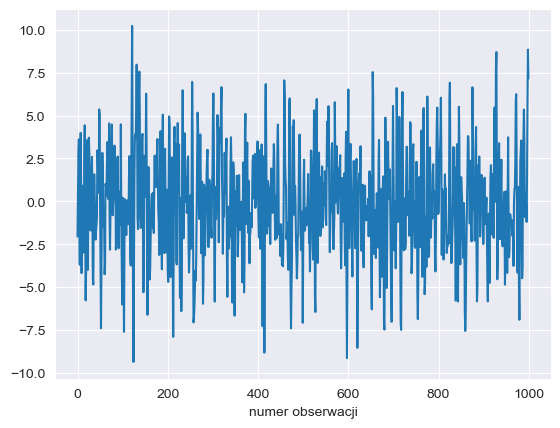

In [56]:
plt.plot(arma_process)
plt.xlabel('numer obserwacji')

In [41]:
# Testowanie stacjonarności
def adfuller_test(series, sig=0.05):
    res = adfuller(series, autolag='AIC')    
    p_value = round(res[1], 3) 
    stats   = round(res[0], 3) 

    if p_value <= sig:
        print(f"Statystyka testowa = {stats}, p-Value = {p_value} => Stationary. ")
    else:
        print(f"Statystyka testowa = {stats}, p-value = {p_value} => Non-stationary.")

In [50]:
adfuller_test(arma_process)

Statystyka testowa = -3.493, p-Value = 0.008 => Stationary. 


### Wizualizacja ACF i PACF

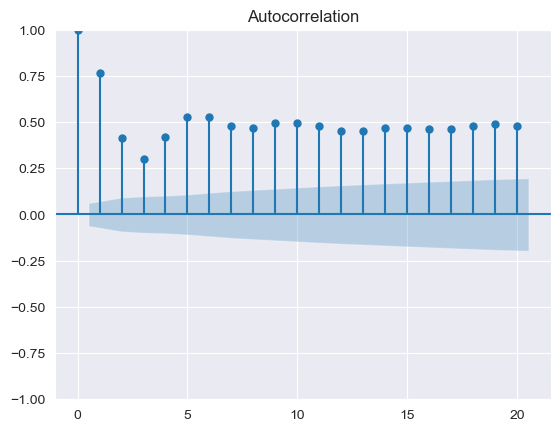

In [54]:
h = 20
plot_acf(arma_process, lags=h, adjusted=True)
plt.show()

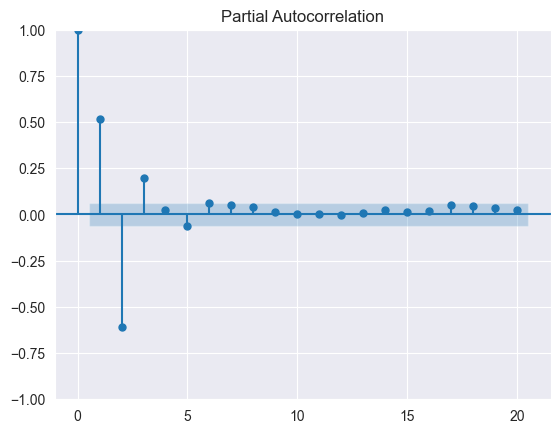

In [7]:
plot_pacf(arma_process, lags=h, method='ywm')
plt.show()

### PACF dla AR

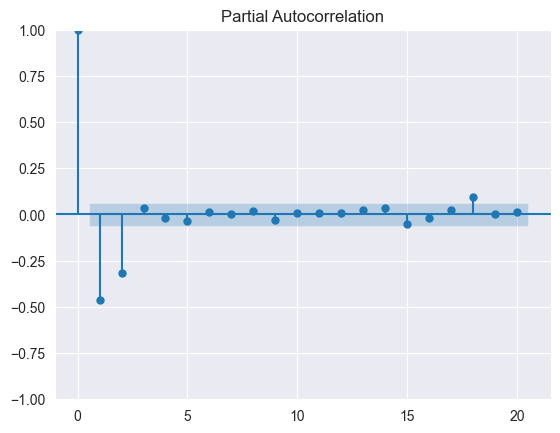

In [8]:
ar_coef0 = np.array([1, q1, q2])
ma_coef0 = np.array([1])
ar_process = ArmaProcess(ar_coef0, ma_coef0).generate_sample(nsample=1000)
plot_pacf(ar_process, lags=h)
plt.show()

### ACF dla MA

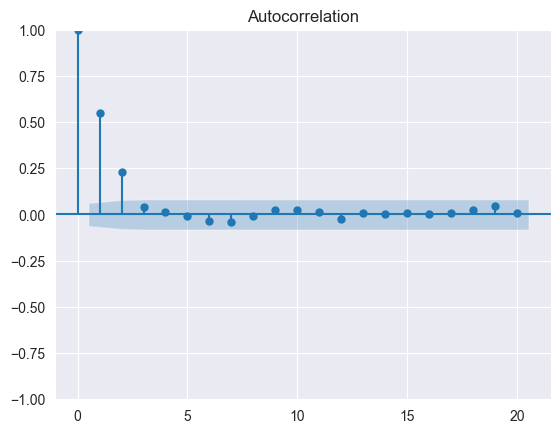

In [9]:
ar_coef1 = np.array([1])
ma_coef1 = np.array([1, q1, q2])
ma_process = ArmaProcess(ar_coef1, ma_coef1).generate_sample(nsample=1000)
plot_acf(ma_process, lags=h)
plt.show()

### Dopasowanie modelu, gdy p i q są znane

In [10]:
p, q = 2, 2

model = ARIMA(arma_process, order=(p, 0, q)).fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1000
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -2077.036
Date:                Thu, 18 Jan 2024   AIC                           4166.073
Time:                        17:59:30   BIC                           4195.519
Sample:                             0   HQIC                          4177.265
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1279      0.101     -1.270      0.204      -0.325       0.070
ar.L1          0.5163      0.058      8.888      0.000       0.402       0.630
ar.L2         -0.5400      0.034    -15.980      0.0

### Residua i parametry modelu

In [11]:
resid = model.resid
params = model.params

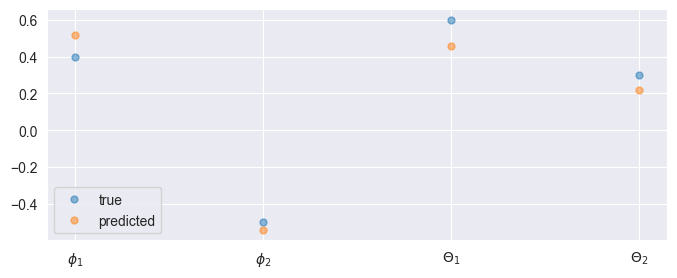

In [12]:
plt.figure(figsize=(8,3))
plt.plot([p1, p2, q1, q2], '.', markersize=10, alpha=0.5)
plt.plot(params[1:-1], '.', markersize=10, alpha=0.5)
plt.legend(['true', 'predicted'])
plt.xticks([0, 1, 2, 3], ['$\phi_1$', '$\phi_2$', '$\Theta_1$', '$\Theta_2$']);

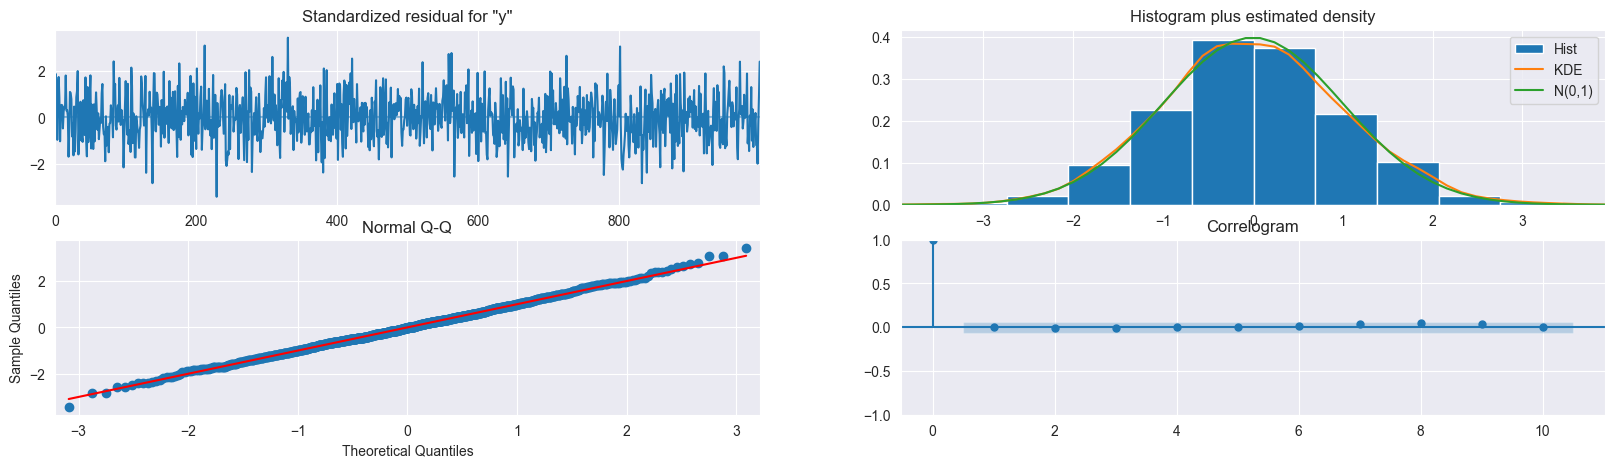

In [13]:
model.plot_diagnostics(0,figsize=(20,5))
plt.plot();

### Znajdownanie rzędu modelu (p, q) za pomocą kryteriów informacyjnych

In [14]:
data = arma_process

df = pd.DataFrame()
ps = []
qs = []
BIC = []
AIC = []
HQIC = []

max_p = 3
max_q = 3

for p in range(0, max_p):
    for q in range(0, max_q):
        model = ARIMA(data, order=(p, 0, q))
        model_fit = model.fit()
        ps.append(p)
        qs.append(q)
        AIC.append(model_fit.aic)
        BIC.append(model_fit.bic)
        HQIC.append(model_fit.hqic)

df['p']    = ps
df['q']    = qs
df['AIC']  = AIC
df['BIC']  = BIC
df['HQIC'] = HQIC

In [15]:
df.sort_values(by='AIC').head()

,p,q,AIC,BIC,HQIC
8,2,2,4166.072932,4195.519463,4177.264669
7,2,1,4177.094803,4201.633579,4186.421250
6,2,0,4211.375981,4231.007003,4218.837139
5,1,2,4271.786788,4296.325565,4281.113236
2,0,2,4273.490883,4293.121904,4280.952040


In [16]:
df.sort_values(by='BIC').head()

,p,q,AIC,BIC,HQIC
8,2,2,4166.072932,4195.519463,4177.264669
7,2,1,4177.094803,4201.633579,4186.421250
6,2,0,4211.375981,4231.007003,4218.837139
2,0,2,4273.490883,4293.121904,4280.952040
5,1,2,4271.786788,4296.325565,4281.113236


In [17]:
df.sort_values(by='HQIC').head()

,p,q,AIC,BIC,HQIC
8,2,2,4166.072932,4195.519463,4177.264669
7,2,1,4177.094803,4201.633579,4186.421250
6,2,0,4211.375981,4231.007003,4218.837139
2,0,2,4273.490883,4293.121904,4280.952040
5,1,2,4271.786788,4296.325565,4281.113236


# Pakiet: pmdarima

Wady: 
- nie przeszukuje kompletnej przestrzeni parametrów jeśli stepwise=True (domyślnie). 
Parametr stepwise (True/False) jest opisany w dokumnentacji jako:

    Czy zastosować algorytm krokowy opisany w Hyndman i Khandakar (2008) w celu zidentyfikowania optymalnych parametrów modelu. Algorytm krokowy może być znacznie szybszy niż dopasowywanie wszystkich (lub randompodzbioru) kombinacji hiperparametrów i jest mniej prawdopodobne, że nadmiernie dopasuje model.

Przykład poniżej: wybrano q z zakresu [1, 3], ale funkcja zakończyła przetwarzanie na rzędzie q=1 (wewnętrzne optymalizacje). Najlepszy uzyskany model to:

        (1) ARIMA(6,0,0)(0,0,0)[0] intercept   : AIC=4256.567, Time=0.25 sec

Gdy niżej ustaliliśmy start_q jako 3, to przeliczyły się q z zakresu [0, 3]. Najlepszy uzyskany model to: 

        (2) ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=4255.408, Time=0.20 sec

Widać, że AIC mniejsze w 2. przypadku, więc ogólnie model ARMA(2,2) jest lepszy.

In [25]:
model2 = pm.auto_arima(arma_process, 
                      d=0,
                      start_p=0, start_q=0, max_d=0,
                      max_p=12, max_q=3, max_order=6,
                      trace=True, seasonal=False,
                      #suppress_warnings=True, 
                       stepwise = True
                      )

# print model summary
print(model2.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=5004.513, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=4688.763, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=4411.053, Time=0.14 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=4359.883, Time=0.12 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=4177.108, Time=0.18 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=4212.030, Time=0.07 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=4171.282, Time=0.31 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=4169.486, Time=0.15 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=4171.171, Time=0.15 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=4170.357, Time=0.49 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=4169.845, Time=0.34 sec

Best model:  ARIMA(3,0,0)(0,0,0)[0]          
Total fit time: 2.057 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1

In [26]:
model2 = pm.auto_arima(arma_process, 
                      d=0,
                      start_p=0, start_q=0, max_d=0, 
                      max_p=12, max_q=3, max_order=6,
                      trace=True, seasonal=False,
                      #suppress_warnings=True, 
                      #stepwise=True
                      )

# print model summary
print(model2.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=5004.513, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=4688.763, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=4411.053, Time=0.15 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=4359.883, Time=0.15 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=4177.108, Time=0.16 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=4212.030, Time=0.12 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=4171.282, Time=0.40 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=4169.486, Time=0.12 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=4171.171, Time=0.18 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=4170.357, Time=0.50 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=4169.845, Time=0.34 sec

Best model:  ARIMA(3,0,0)(0,0,0)[0]          
Total fit time: 2.211 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1

# ... gdy stepwise = False:

In [27]:
model2 = pm.auto_arima(arma_process, 
                      d=0,
                      start_p=0, start_q=0, max_d=0,
                      max_p=12, max_q=3, max_order=6,
                      trace=True, seasonal=False,
                      #suppress_warnings=True, 
                       stepwise = False
                      )

# print model summary
print(model2.summary())

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=5004.513, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=4411.053, Time=0.14 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=4271.997, Time=0.11 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=4259.616, Time=0.16 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=4688.763, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=4359.883, Time=0.15 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=4270.364, Time=0.20 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=4225.179, Time=0.29 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=4212.030, Time=0.12 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=4177.108, Time=0.13 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=4165.696, Time=0.27 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=4167.324, Time=0.40 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=4169.486, Time=0.13 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=4171.282, Time=0.38 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=4167.364, Time=0.57 sec
 ARIMA(3,0

# Wskazówki dotyczące doboru (p, d, q) i inne cenne uwagi:
https://alkaline-ml.com/pmdarima/tips_and_tricks.html#tips-and-tricks

Warto zapoznać się też z informacjami o metodach, jakich autoarima używa do optymalizacji:

https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html

# O przykładowej bibliotece w Julii:
https://lost-stats.github.io/Time_Series/ARIMA-models.html